In [105]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FormatStrFormatter
import glob
import re

%matplotlib inline

In [106]:
abspath = r'C:\Users\Andy\PycharmProjects\finrlpaper2\MT-DRL-Pytorch'
os.chdir(abspath)
cwd_ = os.getcwd() # get current working directory
cwd_

'C:\\Users\\Andy\\PycharmProjects\\finrlpaper2\\MT-DRL-Pytorch'

In [111]:
results_path = "results"

runfolder = "_model_1__addPFVal_mlp_shared_paper_fm2_st_detTrue"

In [112]:
# results "07-18-2021_02-09-48_ppoCustomBase_logU_mlp_shared_paper_fm3_st_detFalse"
results_folder_path =  os.path.join(abspath, 
                                    results_path, 
                                    runfolder)

seed1 = "randomSeed0"
seed2 = "randomSeed5"
seed3 = "randomSeed23"
seed4 = "randomSeed7774"
seed5 = "randomSeed11112"
seedlist = [seed1, seed2, seed3, seed4, seed5]

#### get data

In [113]:
fulldf = pd.read_csv(os.path.join(abspath, "data", "preprocessed", "US_stocks_Wharton_full_DJIA.csv"), index_col=0)
fulldf = fulldf[(fulldf.index >=20151001) & (fulldf.index <=20210406)]
fulldf

,tic,adjcp,high,low,volume,macd,rsi_21,cci_21,dx_21,ret_vola_7d,return_daily,log_return_daily,ret_vola_21d,ret_vola_63d,dow30Close
datadate,,,,,,,,,,,,,,,
20151001,AAPL,27.395,27.4050,26.8275,63849470.0,-0.213248,43.213665,-142.482641,46.629579,0.015355,-0.006528,-0.006549,0.018394,0.021585,16272.01
20151001,AMGN,140.230,140.6400,136.6000,4669185.0,-5.284907,40.669088,-97.725969,45.474166,0.028175,0.013809,0.013714,0.024069,0.022874,16272.01
20151001,AXP,73.890,74.6000,73.2100,4736708.0,-0.765425,43.103747,-104.996290,12.020032,0.012065,-0.003238,-0.003243,0.011729,0.015080,16272.01
20151001,BA,130.610,131.7890,128.9801,2850888.0,-1.665138,43.430153,-62.100748,21.575320,0.014855,-0.002596,-0.002600,0.013862,0.015428,16272.01
20151001,CAT,64.390,66.1000,63.6100,7932525.0,-3.038283,31.633191,-117.979620,52.201438,0.025298,-0.014841,-0.014952,0.020367,0.017881,16272.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20210406,UNH,364.370,369.7900,362.7200,2697863.0,7.370597,57.055247,19.275651,7.728576,0.012503,-0.015695,-0.015820,0.010532,0.013329,33430.24
20210406,VZ,59.110,59.1100,58.6800,12187890.0,0.736307,62.000371,132.417609,41.850301,0.007988,0.004077,0.004068,0.009753,0.012216,33430.24
20210406,WBA,55.700,57.0500,55.5250,4663166.0,1.492350,64.547485,139.529297,45.141083,0.020678,-0.019366,-0.019556,0.020748,0.020207,33430.24


In [114]:
us_df = pd.read_csv(os.path.join(abspath, "data", "preprocessed", "US_stocks_WDB_full.csv"), index_col=0)
us_df = us_df[(us_df.datadate >=20151001) & (us_df.datadate <=20210406)]
us_df.datadate = pd.to_datetime(us_df.datadate, format='%Y%m%d')

### Benchmark 1: dow30 index

In [115]:
dow30 = pd.DataFrame(fulldf["dow30Close"])
dow30.index = pd.to_datetime(dow30.index, format='%Y%m%d')

###  Benchmark 2: equal weighted portfolio

In [116]:
# make equal weights PF
equal_weights = [1/len(fulldf.tic.unique())]*len(fulldf.tic.unique())

In [117]:
full_df_fact = fulldf.reset_index()[["datadate", "tic", "return_daily"]]
full_df_fact.index = full_df_fact.reset_index()["datadate"].factorize()[0]
full_df_fact["equal_weight"] = 1/len(fulldf.tic.unique())
full_df_fact["equal_weighted_return_daily"] = full_df_fact["return_daily"] * full_df_fact["equal_weight"]
full_df_fact["ew_pfret"] = np.NaN

for day in full_df_fact.index.unique():
    pfret = full_df_fact[full_df_fact.index == day]["equal_weighted_return_daily"].sum()
    full_df_fact.loc[full_df_fact.index == day, "ew_pfret"] = pfret
full_df_fact.datadate = pd.to_datetime(full_df_fact.datadate, format='%Y%m%d')
eq_pf = full_df_fact[["datadate", "ew_pfret"]]
eq_pf.drop_duplicates(keep="last", inplace=True)
eq_pf.set_index("datadate", inplace=True)
#eq_pf

c:\users\andy\pycharmprojects\finrlpaper2\mt-drl-pytorch\finrlpapervenv\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [118]:
# create price:
eq_pf["ew_pfret"][0] = 0
eq_pf["cumret"] = (eq_pf["ew_pfret"]+1).cumprod()
#eq_pf

c:\users\andy\pycharmprojects\finrlpaper2\mt-drl-pytorch\finrlpapervenv\lib\site-packages\IPython\core\interactiveshell.py:3437: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\users\andy\pycharmprojects\finrlpaper2\mt-drl-pytorch\finrlpapervenv\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [119]:
#total return by hand:
eq_pf["cumret"][-1] / eq_pf["cumret"][0]-1

1.0692051861309904

In [120]:
# get ew portfolio metrics
import ffn
perf = eq_pf["cumret"].calc_stats()

# now we can access the statistics like this, for example: (ann = annualized)
sharpe_ratio_daily_ann = perf.daily_sharpe
total_return = perf.total_return
#avg_daily_return_ann = perf.daily_mean
std_daily_return_ann = perf.daily_vol
maxdd = perf.max_drawdown
#avg_dd = perf.avg_drawdown
avg_dd_days = perf.avg_drawdown_days

print(sharpe_ratio_daily_ann)
print(total_return)
print(std_daily_return_ann)
print(maxdd)
print(avg_dd_days)

0.7826733132771599
1.0692051861309904
0.1927686096800393
-0.34394496920913964
20.678571428571427


In [121]:
# create mean variance portfolio as benchmark
#import pypfopt
#from pypfopt.efficient_frontier import EfficientFrontier
#from pypfopt import risk_models
#from pypfopt import expected_returns
#from pypfopt.cla import CLA
#from pypfopt.plotting import Plotting
#from matplotlib.ticker import FuncFormatter
# do in colab if time

full_df_fact = fulldf.reset_index()[["datadate", "tic", "return_daily", "volume"]]
full_df_fact

,datadate,tic,return_daily,volume
0,20151001,AAPL,-0.006528,63849470.0
1,20151001,AMGN,0.013809,4669185.0
2,20151001,AXP,-0.003238,4736708.0
3,20151001,BA,-0.002596,2850888.0
4,20151001,CAT,-0.014841,7932525.0
...,...,...,...,...
37444,20210406,UNH,-0.015695,2697863.0
37445,20210406,VZ,0.004077,12187890.0
37446,20210406,WBA,-0.019366,4663166.0
37447,20210406,WMT,0.004805,10328330.0


### Benchmark 3: Volume weighted portfolio

In [122]:
# calculate weekly volume
full_df_fact.index = full_df_fact.reset_index()["datadate"].factorize()[0]

for tic in full_df_fact.tic.unique():
     # note: need to shift by 1 because we only consider volume up to and excluding today to create our weights,
        # since volume normally expressed at the end of the day and not known before portfolio constriûction for the
        # current day
    full_df_fact.loc[full_df_fact.tic == tic, "weekly_volume"] =\
                full_df_fact.loc[full_df_fact.tic == tic, "volume"].shift(-1).rolling(3, min_periods=0).mean()
    

In [123]:
#pd.set_option('display.max_rows', 500)
#full_df_fact[full_df_fact.tic == "AAPL"][0:100]

In [124]:
#full_df_fact

In [125]:
# calculate weekly portfolio volume each day
# create volume weighted pf
# calculate weekly volume for portfolio
for day in full_df_fact.index.unique():
    pfvolweekly = full_df_fact[full_df_fact.index == day]["weekly_volume"].sum()
    full_df_fact.loc[full_df_fact.index == day, "pf_vol_weekly"] = pfvolweekly
full_df_fact.datadate = pd.to_datetime(full_df_fact.datadate, format='%Y%m%d')
#full_df_fact

In [126]:
# calculate volume weights
full_df_fact["volweight"] = full_df_fact["weekly_volume"] / full_df_fact["pf_vol_weekly"]
# calculate volume-weighted return of each stock
full_df_fact["vw_ret"] = full_df_fact["volweight"] * full_df_fact["return_daily"]
# calculate volume-weighted portfolio return
for day in full_df_fact.index.unique():
    pfret = full_df_fact[full_df_fact.index == day]["vw_ret"].sum()
    full_df_fact.loc[full_df_fact.index == day, "vw_pfret"] = pfret
full_df_fact.datadate = pd.to_datetime(full_df_fact.datadate, format='%Y%m%d')
vw_pf = full_df_fact[["datadate", "vw_pfret"]]
vw_pf.drop_duplicates(keep="last", inplace=True)
vw_pf.set_index("datadate", inplace=True)
vw_pf

c:\users\andy\pycharmprojects\finrlpaper2\mt-drl-pytorch\finrlpapervenv\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,vw_pfret
datadate,
2015-10-01,-0.001456
2015-10-02,0.014572
2015-10-05,0.019697
2015-10-06,0.002319
2015-10-07,0.008228
...,...
2021-03-30,-0.008448
2021-03-31,0.005227
2021-04-01,0.008124


In [127]:
# create price:
vw_pf["vw_pfret"][0] = 0 # to ensure that cumret starts at 1 like the model performance
vw_pf["cumret"] = (vw_pf["vw_pfret"]+1).cumprod()
vw_pf

c:\users\andy\pycharmprojects\finrlpaper2\mt-drl-pytorch\finrlpapervenv\lib\site-packages\IPython\core\interactiveshell.py:3437: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\users\andy\pycharmprojects\finrlpaper2\mt-drl-pytorch\finrlpapervenv\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,vw_pfret,cumret
datadate,,
2015-10-01,0.000000,1.000000
2015-10-02,0.014572,1.014572
2015-10-05,0.019697,1.034556
2015-10-06,0.002319,1.036955
2015-10-07,0.008228,1.045487
...,...,...
2021-03-30,-0.008448,2.221146
2021-03-31,0.005227,2.232757
2021-04-01,0.008124,2.250896


In [128]:
# get ew portfolio metrics
import ffn
perf = vw_pf["cumret"].calc_stats()

# now we can access the statistics like this, for example: (ann = annualized)
sharpe_ratio_daily_ann = perf.daily_sharpe
total_return = perf.total_return
#avg_daily_return_ann = perf.daily_mean
std_daily_return_ann = perf.daily_vol
maxdd = perf.max_drawdown
#avg_dd = perf.avg_drawdown
avg_dd_days = perf.avg_drawdown_days

print(sharpe_ratio_daily_ann)
print(total_return)
print(std_daily_return_ann)
print(maxdd)
print(avg_dd_days)

0.800331706990302
1.2744797265435417
0.21596392072574028
-0.34402012452295316
23.905405405405407


## GET PERFORMANCE RESULTS ON TEST SET - MAIN PERFORMANCE

### Get policy actions

In [129]:
policy_actions = []
for seednum, seed in enumerate(seedlist):
    all_li = []
    for ep in range(1,23):
        filepath = os.path.join(results_folder_path, 
                                seed, 
                                "policy_actions", 
                                f"policy_actions_test_ppoCustomBase_ep{ep}_totalSteps_63_finalStateCounter_1.csv")
        df = pd.read_csv(filepath, index_col=0)
        df["datadate"] = pd.to_datetime(df["datadate"], format='%Y%m%d')
        all_li.append(df)
    final_df = pd.concat(all_li, axis=0, ignore_index=True)
    final_df = final_df.drop_duplicates(keep="last")

    policy_actions.append(final_df.set_index("datadate"))
    print(f"seed {seednum+1} done.")
    #plt.plot(final_df.index, (final_df.pfval.pct_change()+1).cumprod())
    #plt.title(f"Seed {seednum+1}: Portfolio Value Test Set over whole Time Series")
    #plt.show()
    # TODO: need to have same axis and axis labels. make randomseed names as numbers (enumaerate)

seed 1 done.
seed 2 done.
seed 3 done.
seed 4 done.
seed 5 done.


### Get transformed policy actions for benchmarking

In [130]:
policy_actions_trans = []
for seednum, seed in enumerate(seedlist):
    all_li = []
    for ep in range(1,23):
        filepath = os.path.join(results_folder_path, 
                                seed, 
                                "policy_actions_trans", 
                                f"policy_actions_trans_test_ppoCustomBase_ep{ep}_totalSteps_63_finalStateCounter_1.csv")
        df = pd.read_csv(filepath, index_col=0)
        df["datadate"] = pd.to_datetime(df["datadate"], format='%Y%m%d')
        all_li.append(df)
    final_df = pd.concat(all_li, axis=0, ignore_index=True)
    final_df = final_df.drop_duplicates(keep="last")

    policy_actions_trans.append(final_df.set_index("datadate"))
    print(f"seed {seednum+1} done.")
    #plt.plot(final_df.index, (final_df.pfval.pct_change()+1).cumprod())
    #plt.title(f"Seed {seednum+1}: Portfolio Value Test Set over whole Time Series")
    #plt.show()
    # TODO: need to have same axis and axis labels. make randomseed names as numbers (enumaerate)

seed 1 done.
seed 2 done.
seed 3 done.
seed 4 done.
seed 5 done.


### portfolio return for all seeds - calculate cumret

In [131]:
### CUMULATIVE PF RETURN OVER TIME, TEST SET

# one plot for each seed, all episodes combined, over all timesteps, cumulative reward on validation set
pfval_al_seeds_li = []
for seednum, seed in enumerate(seedlist):
    all_li = []
    for ep in range(1,23):
        filepath = os.path.join(results_folder_path, 
                                          seed, 
                                          "portfolio_value", 
                                          f"portfolio_value_test_ppoCustomBase_ep{ep}_totalSteps_63_finalStateCounter_1.csv")
        df = pd.read_csv(filepath, index_col=0)
        df.rename(columns={df.columns[1]: "pfval"}, inplace=True)
        df.rename(columns={df.columns[0]: "datadate"}, inplace=True)
        df["datadate"] = pd.to_datetime(df["datadate"], format='%Y%m%d')
        all_li.append(df)
    final_df = pd.concat(all_li, axis=0, ignore_index=True)
    pfval_al_seeds_li.append(final_df.set_index("datadate"))
    print(f"seed {seednum+1} done.")
    #plt.plot(final_df.index, (final_df.pfval.pct_change()+1).cumprod())
    #plt.title(f"Seed {seednum+1}: Portfolio Value Test Set over whole Time Series")
    #plt.show()
pfval_seed_df = pd.concat(pfval_al_seeds_li, axis=1, ignore_index=True)
pfval_seed_df.columns = ["pfval_seed1", "pfval_seed2", "pfval_seed3", "pfval_seed4", "pfval_seed5" ]
pfval_seed_df = pfval_seed_df.drop_duplicates(keep="last")
    # TODO: need to have same axis and axis labels. make randomseed names as numbers (enumaerate)

seed 1 done.
seed 2 done.
seed 3 done.
seed 4 done.
seed 5 done.


In [132]:
pfval_seed_df

,pfval_seed1,pfval_seed2,pfval_seed3,pfval_seed4,pfval_seed5
datadate,,,,,
2015-10-01,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06
2015-10-02,1.000146e+06,1.000168e+06,1.000192e+06,1.000397e+06,1.000243e+06
2015-10-05,1.000746e+06,1.000675e+06,1.000984e+06,1.001848e+06,1.001120e+06
2015-10-06,1.000744e+06,1.000616e+06,1.000844e+06,1.001263e+06,1.001282e+06
2015-10-07,1.001452e+06,1.001082e+06,1.001239e+06,1.002690e+06,1.001943e+06
...,...,...,...,...,...
2021-03-30,2.222978e+06,2.526552e+06,2.507069e+06,1.982538e+06,2.691366e+06
2021-03-31,2.229282e+06,2.525860e+06,2.519682e+06,1.977313e+06,2.690544e+06
2021-04-01,2.221801e+06,2.546248e+06,2.508822e+06,1.962280e+06,2.737437e+06


In [133]:
dow30.drop_duplicates(keep="last", inplace=True)
#dow30

In [134]:
# concatenate pfval seed with dow30, as this will make it easier to plot
pfval_full = pd.concat([pfval_seed_df, dow30], axis=1, ignore_index=True)
# concatenate pfval seed with dow30, as this will make it easier to plot
pfval_full = pd.concat([pfval_full, eq_pf.drop(columns=["cumret"])], axis=1, ignore_index=True)
# concatenate pfval seed with equal weighted PF, as this will make it easier to plot
pfval_full = pd.concat([pfval_full, vw_pf.drop(columns=["cumret"])], axis=1, ignore_index=True)
pfval_full.columns = ["Seed 1", "Seed 2", "Seed 3", "Seed 4", "Seed 5", "Dow30", "Equal Weights PF", "Volume Weights PF"]
pfval_full

,Seed 1,Seed 2,Seed 3,Seed 4,Seed 5,Dow30,Equal Weights PF,Volume Weights PF
datadate,,,,,,,,
2015-10-01,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,16272.01,0.000000,0.000000
2015-10-02,1.000146e+06,1.000168e+06,1.000192e+06,1.000397e+06,1.000243e+06,16472.37,0.013765,0.014572
2015-10-05,1.000746e+06,1.000675e+06,1.000984e+06,1.001848e+06,1.001120e+06,16776.43,0.019710,0.019697
2015-10-06,1.000744e+06,1.000616e+06,1.000844e+06,1.001263e+06,1.001282e+06,16790.19,-0.001709,0.002319
2015-10-07,1.001452e+06,1.001082e+06,1.001239e+06,1.002690e+06,1.001943e+06,16912.29,0.009284,0.008228
...,...,...,...,...,...,...,...,...
2021-03-30,2.222978e+06,2.526552e+06,2.507069e+06,1.982538e+06,2.691366e+06,33066.96,-0.004686,-0.008448
2021-03-31,2.229282e+06,2.525860e+06,2.519682e+06,1.977313e+06,2.690544e+06,32981.55,-0.001633,0.005227
2021-04-01,2.221801e+06,2.546248e+06,2.508822e+06,1.962280e+06,2.737437e+06,33153.21,0.004548,0.008124


#### Get portfolio weights incl. cash: list with 1 df for each of the 5 seeds

In [135]:
### CUMULATIVE PF RETURN OVER TIME, TEST SET

# one plot for each seed, all episodes combined, over all timesteps, cumulative reward on validation set
weightsinclcash_seed_list = []
for seednum, seed in enumerate(seedlist):
    all_li = []
    for ep in range(1,23):
        filepath = os.path.join(results_folder_path, 
                                seed, 
                                "all_weights_cashAtEnd", 
                                f"all_weights_cashAtEnd_test_ppoCustomBase_ep{ep}_totalSteps_63_finalStateCounter_1.csv")
        df = pd.read_csv(filepath, index_col=0)
        df["datadate"] = pd.to_datetime(df["datadate"], format='%Y%m%d')
        all_li.append(df)
    final_df = pd.concat(all_li, axis=0, ignore_index=True)
    final_df = final_df.drop_duplicates(keep="last")

    weightsinclcash_seed_list.append(final_df.set_index("datadate"))
    print(f"seed {seednum+1} done.")
    #plt.plot(final_df.index, (final_df.pfval.pct_change()+1).cumprod())
    #plt.title(f"Seed {seednum+1}: Portfolio Value Test Set over whole Time Series")
    #plt.show()
    # TODO: need to have same axis and axis labels. make randomseed names as numbers (enumaerate)

seed 1 done.
seed 2 done.
seed 3 done.
seed 4 done.
seed 5 done.


#### Get transaction cost for each seed

In [136]:
### CUMULATIVE PF RETURN OVER TIME, TEST SET

# one plot for each seed, all episodes combined, over all timesteps, cumulative reward on validation set
all_seeds_li = []
for seednum, seed in enumerate(seedlist):
    all_li = []
    for ep in range(1,23):
        filepath = os.path.join(results_folder_path, 
                                          seed, 
                                          "transaction_cost", 
                                          f"transaction_cost_test_ppoCustomBase_ep{ep}_totalSteps_63_finalStateCounter_1.csv")
        df = pd.read_csv(filepath, index_col=0)
        df.rename(columns={df.columns[1]: "pfval"}, inplace=True)
        df.rename(columns={df.columns[0]: "datadate"}, inplace=True)
        df["datadate"] = pd.to_datetime(df["datadate"], format='%Y%m%d')
        all_li.append(df)
    final_df = pd.concat(all_li, axis=0, ignore_index=True)
    all_seeds_li.append(final_df.set_index("datadate"))
    print(f"seed {seednum+1} done.")
    #plt.plot(final_df.index, (final_df.pfval.pct_change()+1).cumprod())
    #plt.title(f"Seed {seednum+1}: Portfolio Value Test Set over whole Time Series")
    #plt.show()
tc_seed_df = pd.concat(all_seeds_li, axis=1, ignore_index=True)
tc_seed_df.columns = ["tc_seed1", "tc_seed2", "tc_seed3", "tc_seed4", "tc_seed5" ]
tc_seed_df = tc_seed_df.drop_duplicates(keep="last")
    # TODO: need to have same axis and axis labels. make randomseed names as numbers (enumaerate)

seed 1 done.
seed 2 done.
seed 3 done.
seed 4 done.
seed 5 done.


In [137]:
# summarize data we have
fulldf # stock prices + dow30
us_df # stock prices
weightsinclcash_seed_list
pfval_full
tc_seed_df

,tc_seed1,tc_seed2,tc_seed3,tc_seed4,tc_seed5
datadate,,,,,
2015-10-01,13.709625,13.868475,15.407010,34.194980,23.190545
2015-10-02,19.606570,19.157420,27.707585,42.370220,23.232035
2015-10-05,19.745520,24.340960,29.515835,37.417165,22.244860
2015-10-06,22.907872,22.730175,26.532087,38.942033,26.106648
2015-10-07,14.300260,24.024640,22.564410,37.182900,25.586425
...,...,...,...,...,...
2021-03-30,3.332230,10.578320,17.621410,0.000000,55.233510
2021-03-31,0.000000,10.986010,49.023870,0.000000,54.946830
2021-04-01,26.298110,1.386900,87.453120,12.589640,123.504740


# PLOTS

## Plot for cumulative return of best and worst and mean seed vs. benchmarks

In [138]:
pfval_full["mean"] = (pfval_full["Seed 1"]+pfval_full["Seed 2"]+
                      pfval_full["Seed 3"]+pfval_full["Seed 4"]+pfval_full["Seed 5"])/5
pfval_full
# note: best is seed 5, worst seed 4

,Seed 1,Seed 2,Seed 3,Seed 4,Seed 5,Dow30,Equal Weights PF,Volume Weights PF,mean
datadate,,,,,,,,,
2015-10-01,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,16272.01,0.000000,0.000000,1.000000e+06
2015-10-02,1.000146e+06,1.000168e+06,1.000192e+06,1.000397e+06,1.000243e+06,16472.37,0.013765,0.014572,1.000229e+06
2015-10-05,1.000746e+06,1.000675e+06,1.000984e+06,1.001848e+06,1.001120e+06,16776.43,0.019710,0.019697,1.001075e+06
2015-10-06,1.000744e+06,1.000616e+06,1.000844e+06,1.001263e+06,1.001282e+06,16790.19,-0.001709,0.002319,1.000950e+06
2015-10-07,1.001452e+06,1.001082e+06,1.001239e+06,1.002690e+06,1.001943e+06,16912.29,0.009284,0.008228,1.001681e+06
...,...,...,...,...,...,...,...,...,...
2021-03-30,2.222978e+06,2.526552e+06,2.507069e+06,1.982538e+06,2.691366e+06,33066.96,-0.004686,-0.008448,2.386101e+06
2021-03-31,2.229282e+06,2.525860e+06,2.519682e+06,1.977313e+06,2.690544e+06,32981.55,-0.001633,0.005227,2.388536e+06
2021-04-01,2.221801e+06,2.546248e+06,2.508822e+06,1.962280e+06,2.737437e+06,33153.21,0.004548,0.008124,2.395318e+06


In [139]:
us_df

,datadate,tic,adjcp,high,low,volume,macd,rsi_21,cci_21,dx_21,ret_vola_7d,return_daily,log_return_daily,ret_vola_21d,ret_vola_63d,obv,vixDiv100
106947,2015-10-01,AAPL,27.395,27.4050,26.8275,63849470.0,-0.213248,43.213665,-142.482641,46.629579,0.015355,-0.006528,-0.006549,0.018394,0.021585,2.540938e+09,0.2255
106948,2015-10-01,AMGN,140.230,140.6400,136.6000,4669185.0,-5.284907,40.669088,-97.725969,45.474166,0.028175,0.013809,0.013714,0.024069,0.022874,2.597932e+08,0.2255
106949,2015-10-01,AXP,73.890,74.6000,73.2100,4736708.0,-0.765425,43.103747,-104.996290,12.020032,0.012065,-0.003238,-0.003243,0.011729,0.015080,3.895716e+08,0.2255
106950,2015-10-01,BA,130.610,131.7890,128.9801,2850888.0,-1.665138,43.430153,-62.100748,21.575320,0.014855,-0.002596,-0.002600,0.013862,0.015428,1.307070e+08,0.2255
106951,2015-10-01,CAT,64.390,66.1000,63.6100,7932525.0,-3.038283,31.633191,-117.979620,52.201438,0.025298,-0.014841,-0.014952,0.020367,0.017881,-6.605129e+07,0.2255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144391,2021-04-06,UNH,364.370,369.7900,362.7200,2697863.0,7.370597,57.055247,19.275651,7.728576,0.012503,-0.015695,-0.015820,0.010532,0.013329,3.443571e+08,0.1812
144392,2021-04-06,VZ,59.110,59.1100,58.6800,12187890.0,0.736307,62.000371,132.417609,41.850301,0.007988,0.004077,0.004068,0.009753,0.012216,1.100136e+08,0.1812
144393,2021-04-06,WBA,55.700,57.0500,55.5250,4663166.0,1.492350,64.547485,139.529297,45.141083,0.020678,-0.019366,-0.019556,0.020748,0.020207,-6.175329e+06,0.1812
144394,2021-04-06,WMT,140.100,140.9482,138.5200,10328330.0,0.706261,57.499379,197.681762,46.171494,0.011346,0.004805,0.004794,0.011360,0.013792,6.024730e+08,0.1812


### STOCKS PLOT

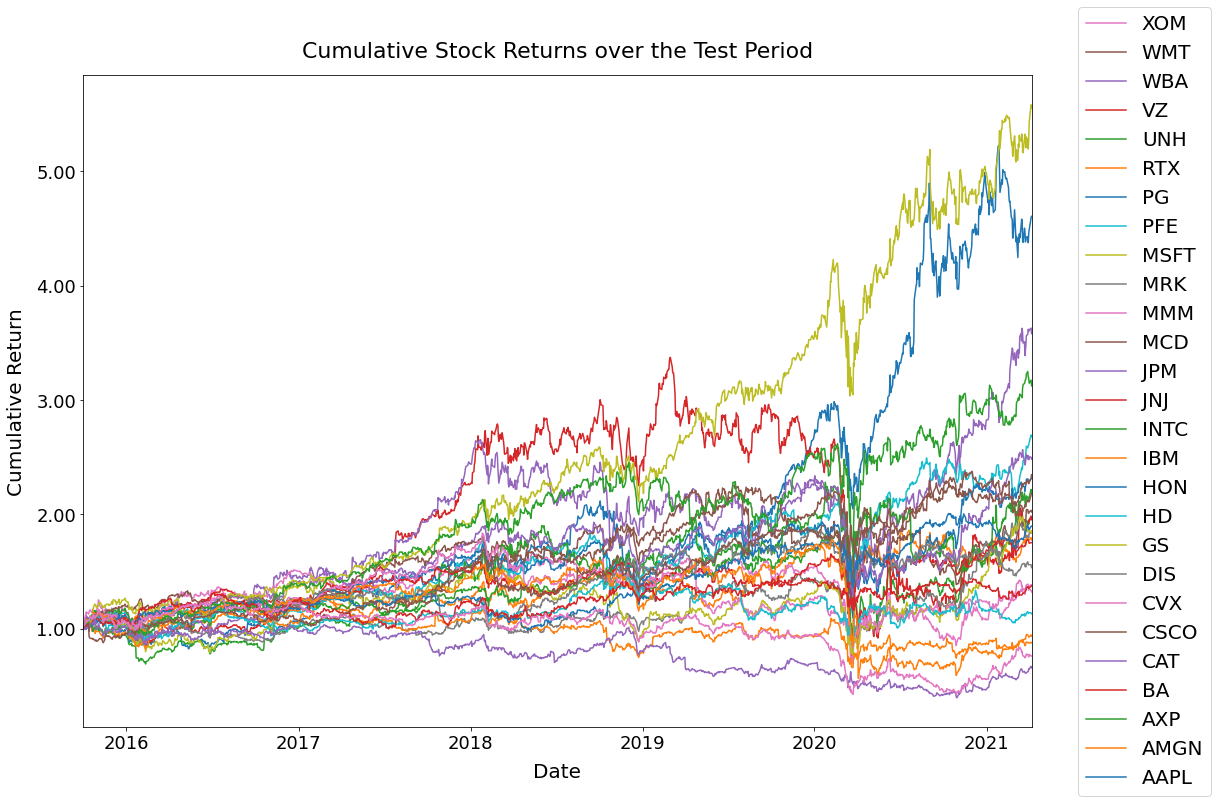

In [140]:
subplots = 1
%matplotlib inline
space_between_plots=0.5
title_pad = 18.
label_pad = 10.
legend_borderpad = 0.9
legend_location= "right"
legend_location_exact = (1.2, 0.5) # (x, y, width, height)
legend_borderaxespad = 0.

title_fontsize = 22
label_fontsize = 20
tickfont = 18
legend_fontsize = 25


titles_list = ["Cumulative Stock Returns over the Test Period"]
x_labels_list = ["Date"]*subplots
y_labels_list = ["Cumulative Return"]

fig, ax = plt.subplots(nrows=subplots, ncols=1, figsize=(17,12),
                       gridspec_kw={
                           'width_ratios': [1],
                           'height_ratios': [1], 
                           'wspace': 0.1, 'hspace':space_between_plots})
# plot cumulative returns
ax.tick_params(axis='x', labelsize=tickfont)
ax.tick_params(axis='y', labelsize=tickfont)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_xlim(us_df.datadate.unique()[0], us_df.datadate.unique()[-1])
#ax[0].set_ylim(-2, 0.7)
ax.set_title(titles_list[0], fontsize=title_fontsize, pad=title_pad)
ax.set_xlabel(x_labels_list[0], fontsize=label_fontsize, labelpad=label_pad)
ax.set_ylabel(y_labels_list[0], fontsize=label_fontsize, labelpad=label_pad)

for tic in us_df.tic.unique(): 
    subset = us_df[us_df.tic==tic]["adjcp"]
    
    #line, = ax[0].plot(pfval_full.index, np.log((pfval_full[col].pct_change()+1).cumprod()), label=col)
    ax.plot(us_df.datadate.unique(), 
                    (subset.pct_change()+1).cumprod(), label=tic)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc=legend_location, bbox_to_anchor=legend_location_exact, 
         prop=dict(size=label_fontsize))


plt.savefig(os.path.join(abspath, "analysis", "results", "stock_cumretreturns.png"), bbox_inches="tight")

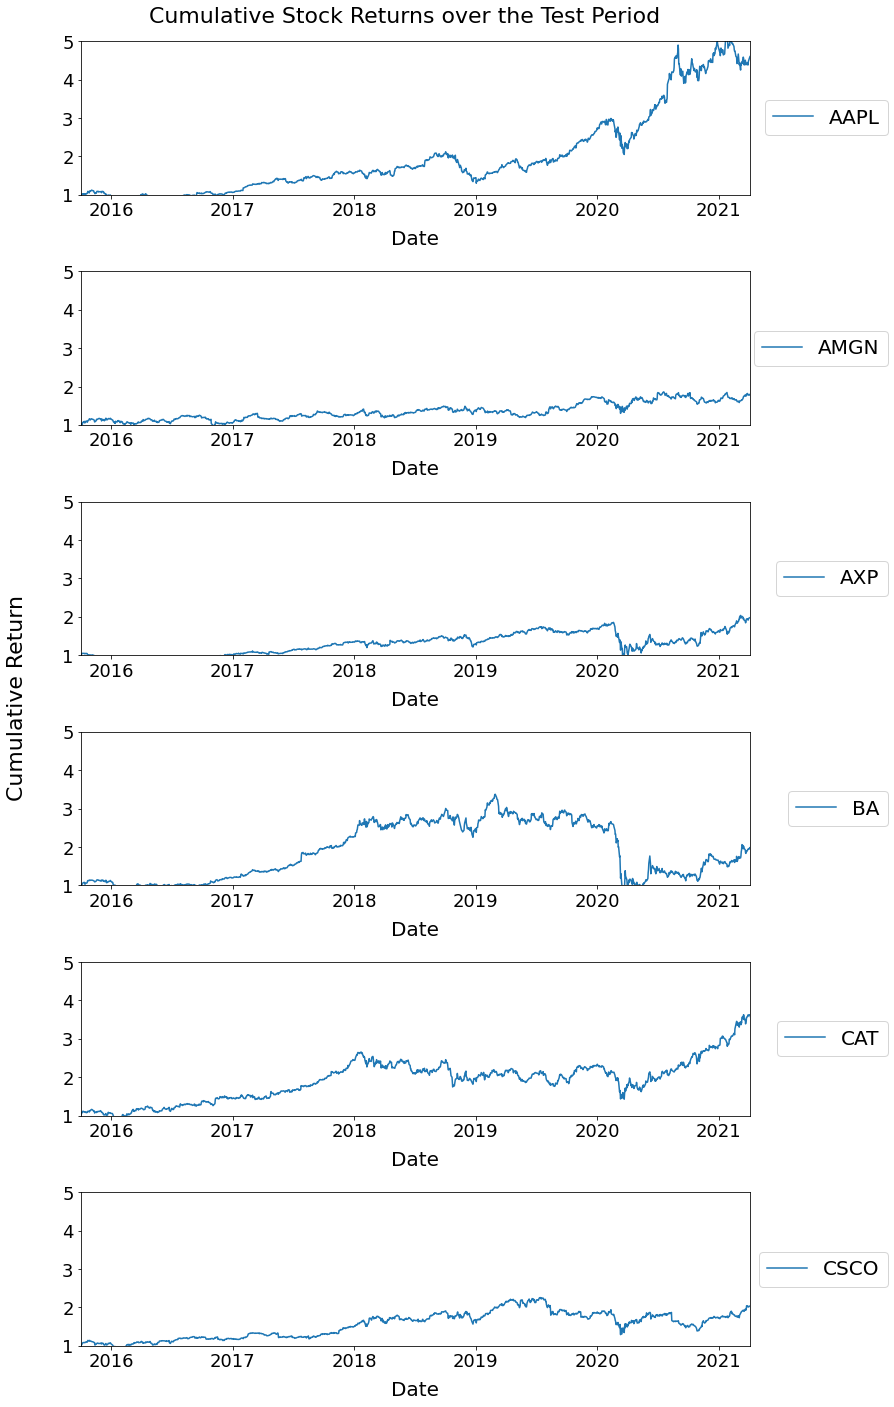

In [141]:
%matplotlib inline
subplots = 6

space_between_plots=0.5
title_pad = 18.
label_pad = 10.
legend_borderpad = 0.9
legend_location= "right"
legend_location_exact = (1.22, 0.5) # (x, y, width, height)
legend_borderaxespad = 0.

title_fontsize = 22
label_fontsize = 20
tickfont = 18
legend_fontsize = 25


titles_list = ["Cumulative Stock Returns over the Test Period"]
x_labels_list = ["Date"]*subplots
y_labels_list = ["Cumulative Return"]

fig, ax = plt.subplots(nrows=subplots, ncols=1, figsize=(12,24), sharey = True, 
                       gridspec_kw={
                           'width_ratios': [1],
                           'height_ratios': [1]*subplots, 
                           'wspace': 0.1, 'hspace':space_between_plots})


labels=['AAPL', 'AMGN', 'AXP', 'BA', 'CAT', 'CSCO', 'CVX', 'DIS', 'GS', 'HD',
                          'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'PFE',
                          'PG', 'RTX', 'UNH', 'VZ', 'WBA', 'WMT', 'XOM', 'Cash']

fig.suptitle(titles_list[0], fontsize=title_fontsize, y=0.9)
fig.text(0.04, 0.5, 'Cumulative Return', va='center', rotation='vertical', fontsize=22)
### first 10 companies
for seednum, tic in enumerate(us_df.tic.unique()[:subplots]):
    axindex = seednum
    subset = us_df[us_df.tic==tic]["adjcp"]
    ax[axindex].tick_params(axis='x', labelsize=tickfont)
    ax[axindex].tick_params(axis='y', labelsize=tickfont)
    ax[axindex].set_xlim(us_df.datadate.unique()[0], us_df.datadate.unique()[-1])
    ax[axindex].set_ylim(1, 5)
    #ax[axindex].set_title(titles_list[0]+f" {tic}", fontsize=title_fontsize, pad=title_pad)
    ax[axindex].set_xlabel(x_labels_list[0], fontsize=label_fontsize, labelpad=label_pad)
    #ax[axindex].set_ylabel(y_labels_list[0], fontsize=label_fontsize, labelpad=label_pad)
    ax[axindex].plot(us_df.datadate.unique(), 
                    (subset.pct_change()+1).cumprod(), label=tic)
    
    handles, labels = ax[axindex].get_legend_handles_labels()
    ax[axindex].legend(handles[::-1], labels[::-1], loc=legend_location, bbox_to_anchor=legend_location_exact, 
             prop=dict(size=label_fontsize))

    
#lines_list = [lines_list[0][::-1]]
#labels = labels[::-1]

#fig.legend(lines_list, labels=labels, loc=legend_location,
#               bbox_to_anchor=legend_location_exact,  # (x, y, width, height) 
#               borderaxespad=legend_borderaxespad,
##               borderpad=legend_borderpad, fontsize=legend_fontsize,
               #ncol=1)
#fig.tight_layout()
#fig.subplots_adjust(hspace=space_between_plots)
#ax[0].legend(loc='upper right')

plt.savefig(os.path.join(abspath, "analysis", "results", "stock_cumret_single1.png"), bbox_inches="tight")

### PERFORMANCE ALL SEEDS FOR APPENDIX

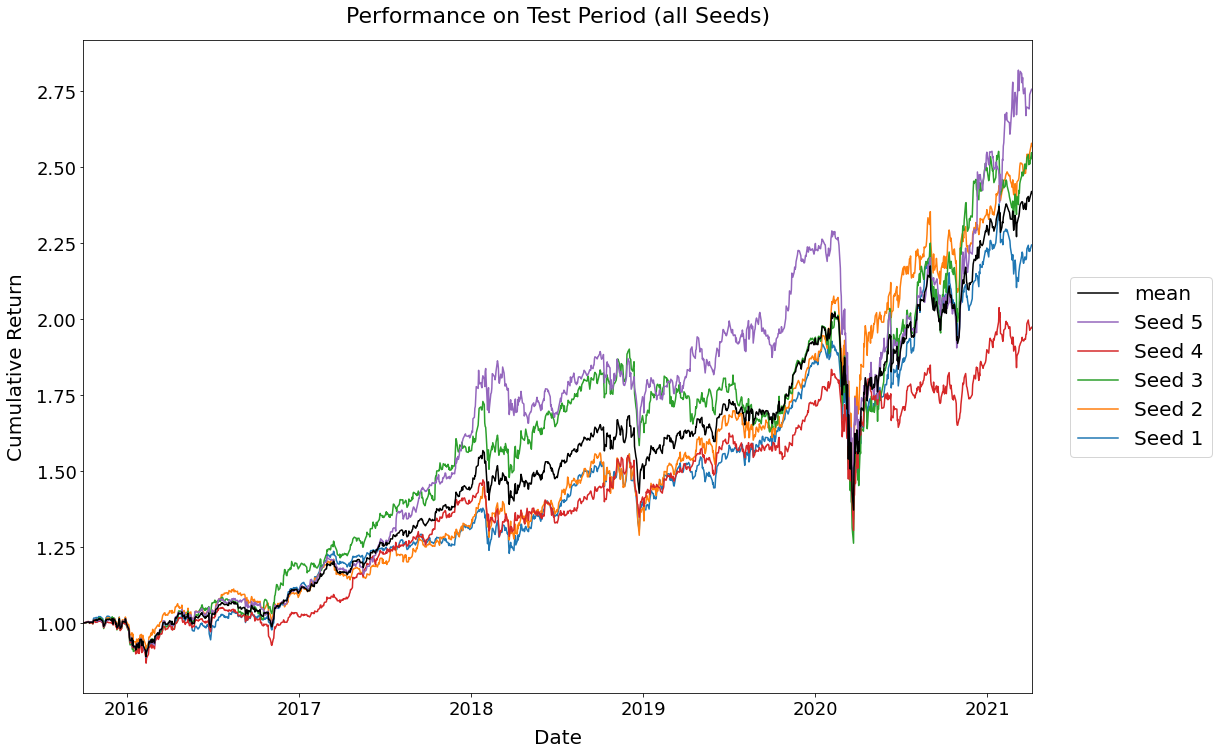

In [142]:
subplots = 1

space_between_plots=0.5
title_pad = 18.
label_pad = 10.
legend_borderpad = 0.9
legend_location= "right"
legend_location_exact = (1.2, 0.5) # (x, y, width, height)
legend_borderaxespad = 0.

title_fontsize = 22
label_fontsize = 20
tickfont = 18
legend_fontsize = 25


titles_list = ["Performance on Test Period (all Seeds)"]
x_labels_list = ["Date"]*subplots
y_labels_list = ["Cumulative Return"]

fig, ax = plt.subplots(nrows=subplots, ncols=1, figsize=(17,12),
                       gridspec_kw={
                           'width_ratios': [1],
                           'height_ratios': [1], 
                           'wspace': 0.1, 'hspace':space_between_plots})

for col in pfval_full.columns.values[:-4]: # note: the last three are benchmarks
    # plot cumulative returns
    ax.tick_params(axis='x', labelsize=tickfont)
    ax.tick_params(axis='y', labelsize=tickfont)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.set_xlim(pfval_full.index[0], pfval_full.index[-1])
    #ax[0].set_ylim(-2, 0.7)
    ax.set_title(titles_list[0], fontsize=title_fontsize, pad=title_pad)
    ax.set_xlabel(x_labels_list[0], fontsize=label_fontsize, labelpad=label_pad)
    ax.set_ylabel(y_labels_list[0], fontsize=label_fontsize, labelpad=label_pad)
    #line, = ax[0].plot(pfval_full.index, np.log((pfval_full[col].pct_change()+1).cumprod()), label=col)
    ax.plot(pfval_full.index, (pfval_full[col].pct_change()+1).cumprod(), label=col)

ax.plot(pfval_full.index,(pfval_full["mean"].pct_change()+1).cumprod(), label="mean", color="black")

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc=legend_location, bbox_to_anchor=legend_location_exact, 
         prop=dict(size=label_fontsize))


# we see: te best seed is seed 5, the worst is seed 4

plt.savefig(os.path.join(abspath, "analysis", "results", "model1", "model1_allseeds_cumret.png"), bbox_inches="tight")

## PERFORMANCE PLOT and TC

- Performance best and worst seed vs benchmarks
- Transaction cost

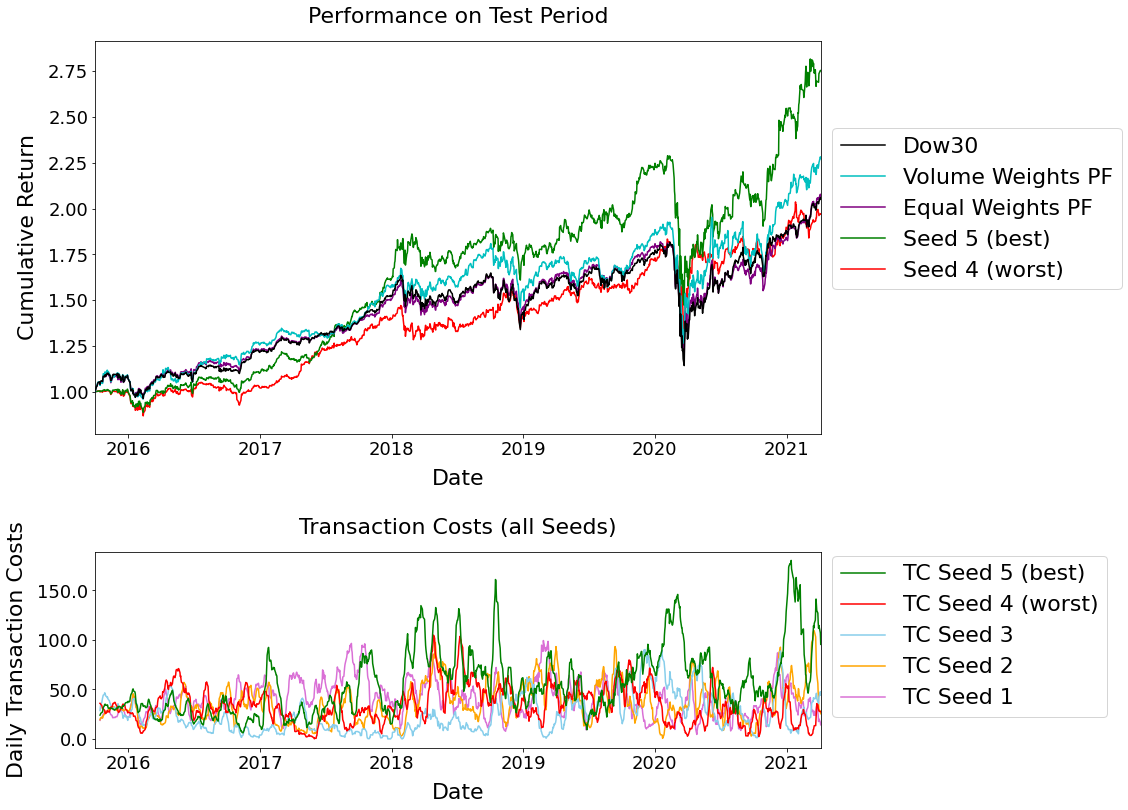

In [143]:
subplots = 2

title_pad = 18.
label_pad = 10.

space_between_plots=0.4
legend_borderpad = 0.9
legend_borderaxespad = 0.

legend_location= "lower right"
legend_location_exact = (1.43, 0.34) # (x, y, width, height)

title_fontsize = 22
label_fontsize = 22
legend_fontsize = 18
tickfont = 18


titles_list = ["Performance on Test Period", 
              "Transaction Costs (all Seeds)"]
x_labels_list = ["Date"]*subplots
y_labels_list = ["Cumulative Return", "Daily Transaction Costs"]

fig, ax = plt.subplots(nrows=subplots, ncols=1, figsize=(13,13),#(17,17),
                       gridspec_kw={
                           'width_ratios': [1],
                           'height_ratios': [2,1], 
                           'wspace': 0.1, 'hspace':space_between_plots})


####  CUMULATIVE RETURNS
ax[0].tick_params(axis='x', labelsize=tickfont)
ax[0].tick_params(axis='y', labelsize=tickfont)
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax[0].set_xlim(pfval_full.index[0], pfval_full.index[-1])
#ax[0].set_ylim(-2, 0.7)
ax[0].set_title(titles_list[0], fontsize=title_fontsize, pad=title_pad)
ax[0].set_xlabel(x_labels_list[0], fontsize=label_fontsize, labelpad=label_pad)
ax[0].set_ylabel(y_labels_list[0], fontsize=label_fontsize, labelpad=label_pad)
#line, = ax[0].plot(pfval_full.index, np.log((pfval_full[col].pct_change()+1).cumprod()), label=col)

# best and worst seed
for column, color, label in zip(["Seed 4", "Seed 5"], ["red", "green"], ["Seed 4 (worst)", "Seed 5 (best)"]):
    ax[0].plot(pfval_full.index, (pfval_full[column].pct_change()+1).cumprod(), label=label, 
                      color=color)

# Equal Weights PF
ax[0].plot(pfval_full.index,(pfval_full["Equal Weights PF"]+1).cumprod(), 
                   label="Equal Weights PF", color="purple")
# Volume Weights PF
ax[0].plot(pfval_full.index,(pfval_full["Volume Weights PF"]+1).cumprod(), 
                   label="Volume Weights PF", color="c")
# Dow30
ax[0].plot(pfval_full.index,(pfval_full["Dow30"].pct_change()+1).cumprod(), 
                   label="Dow30", color="black")


handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles[::-1], labels[::-1], loc=legend_location, bbox_to_anchor=legend_location_exact, 
            prop=dict(size=label_fontsize))


#### TRANSACTION COST
legend_location= "lower right"
legend_location_exact = (1.41, .10) # (x, y, width, height)

for col, color, label in zip(tc_seed_df.columns.values, ["orchid", "orange", "skyblue", "red", "green"],
                            ["TC Seed 1","TC Seed 2", "TC Seed 3", "TC Seed 4 (worst)", "TC Seed 5 (best)" ]):
    ax[1].tick_params(axis='x', labelsize=tickfont)
    ax[1].tick_params(axis='y', labelsize=tickfont)
    ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax[1].set_xlim(tc_seed_df.index[0], tc_seed_df.index[-1])
    #ax[1].set_ylim(-1, 0.7)
    ax[1].set_title(titles_list[1], fontsize=title_fontsize, pad=title_pad)
    ax[1].set_xlabel(x_labels_list[1], fontsize=label_fontsize, labelpad=label_pad)
    ax[1].set_ylabel(y_labels_list[1], fontsize=label_fontsize, labelpad=label_pad)
    ax[1].plot(tc_seed_df.index, tc_seed_df[col].rolling(window=10).mean(), label=label, 
                      color=color)
handles, labels = ax[1].get_legend_handles_labels()
# reverse the order
ax[1].legend(handles[::-1], labels[::-1], loc=legend_location, bbox_to_anchor=legend_location_exact, 
            prop=dict(size=label_fontsize))
             
             
plt.savefig(os.path.join(abspath, "analysis", "results", "model1", "model1_bestworstseeds_cumret_tc.png"), 
            bbox_inches="tight")

### FINAL WEIGHTS PLOT

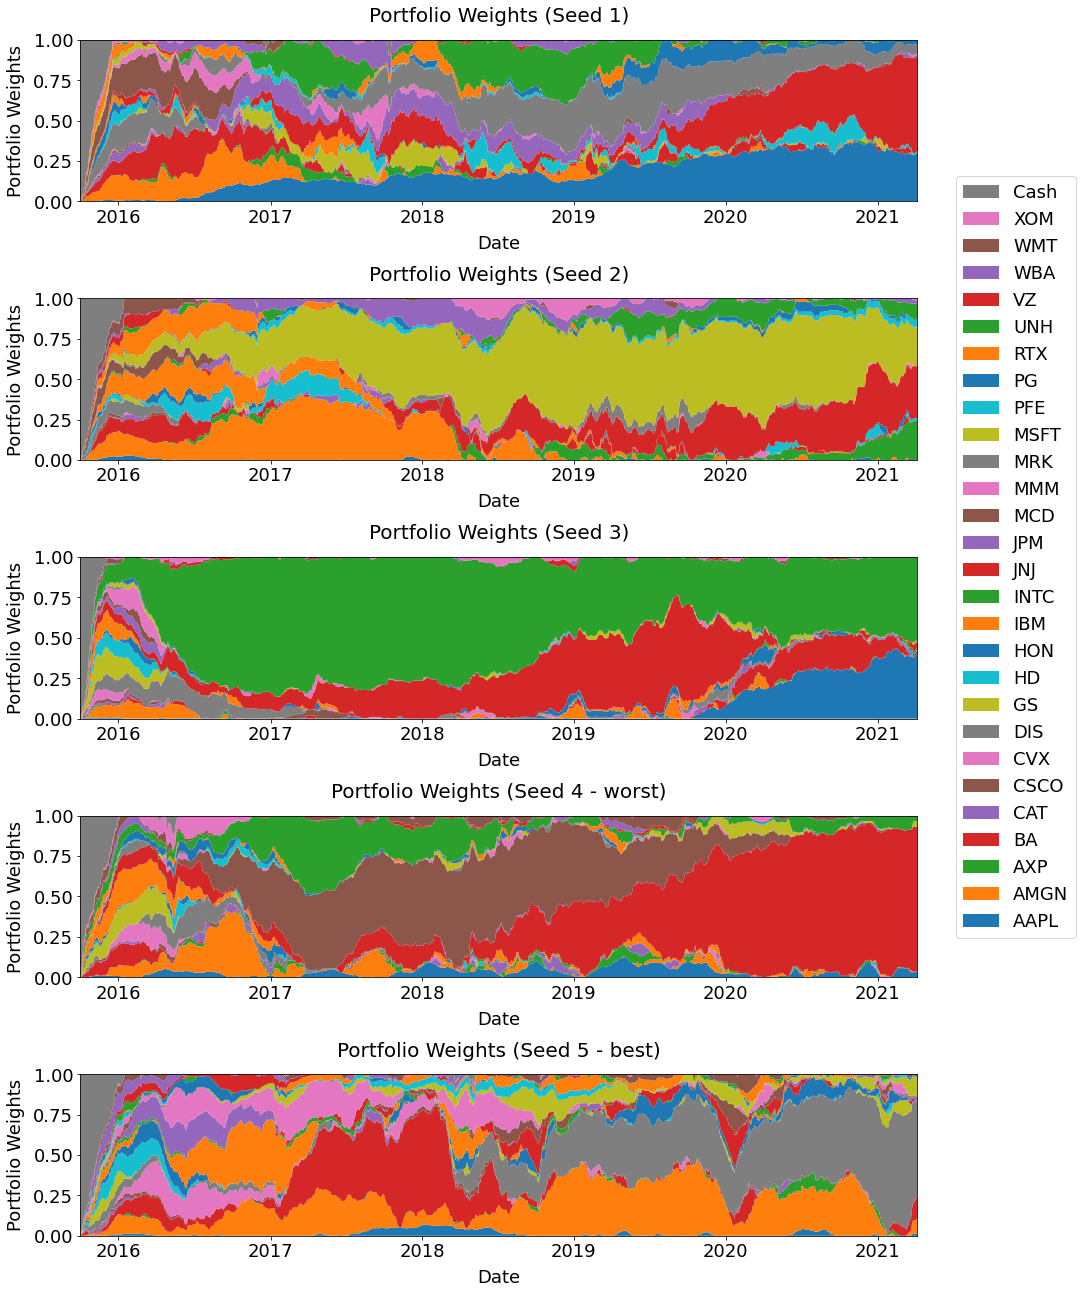

In [39]:
### SEPARATE PLOT FOR PORTFOLIO WEIGHTS BECAUSE ELSE IT IS MESSY

subplots = len(weightsinclcash_seed_list)

title_pad = 18.
label_pad = 8#10.
titles_list = [ "Portfolio Weights (Seed 1)", "Portfolio Weights (Seed 2)", 
              "Portfolio Weights (Seed 3)", "Portfolio Weights (Seed 4 - worst)", "Portfolio Weights (Seed 5 - best)"]
x_labels_list = ["Date"]*subplots
y_labels_list = ["Portfolio Weights", "Portfolio Weights", 
              "Portfolio Weights", "Portfolio Weights", "Portfolio Weights"]
legend_location= "right"
legend_location_exact = (1.2,1)#(0.01, -0.04, 1.12, 1.1) # (right_loc, loc,up_loc, right_loc, up_loc) = (right_loc, up_loc), 
                                            # in relation to legend_location
legend_borderpad = 0.9
legend_borderaxespad = 0.
legend_fontsize = 16.
space_between_plots=0.6
lines_list = []

title_fontsize = 20
label_fontsize = 18
tickfont = 18

fig, ax = plt.subplots(nrows=subplots, 
                       ncols=1, 
                       figsize=(15,22),
                       gridspec_kw={
                           'width_ratios': [1],
                           'height_ratios': [1, 1, 1, 1, 1], 
                           'wspace': 0.1, 'hspace': space_between_plots})


labels=['AAPL', 'AMGN', 'AXP', 'BA', 'CAT', 'CSCO', 'CVX', 'DIS', 'GS', 'HD',
                          'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'PFE',
                          'PG', 'RTX', 'UNH', 'VZ', 'WBA', 'WMT', 'XOM', 'Cash']


for seednum, wdf in enumerate(weightsinclcash_seed_list):
    axindex = seednum
    #ax[axindex].set_prop_cycle('color', [cm(1 * i / NUM_COLORS) for i in range(NUM_COLORS)])
    ax[axindex].tick_params(axis='x', labelsize=tickfont)
    ax[axindex].tick_params(axis='y', labelsize=tickfont)
    ax[axindex].set_xlim(wdf.index[0], wdf.index[-1])
    ax[axindex].set_ylim(0, 1)
    ax[axindex].set_title(titles_list[axindex], fontsize=title_fontsize, pad=title_pad)
    ax[axindex].set_xlabel(x_labels_list[axindex], fontsize=label_fontsize, labelpad=label_pad)
    ax[axindex].set_ylabel(y_labels_list[axindex], fontsize=label_fontsize, labelpad=label_pad)

    if axindex == 2:
        ax[axindex].stackplot(wdf.index, 
                              wdf["AAPL"], wdf["AMGN"],wdf["AXP"], wdf["BA"], wdf["CAT"], wdf["CSCO"],
                              wdf["CVX"], wdf["DIS"], wdf["GS"], wdf["HD"], wdf["HON"], wdf["IBM"], wdf["INTC"], 
                              wdf["JNJ"], wdf["JPM"], wdf["MCD"], wdf["MMM"], wdf["MRK"], wdf["MSFT"], wdf["PFE"], 
                              wdf["PG"], wdf["RTX"], wdf["UNH"], wdf["VZ"], wdf["WBA"], wdf["WMT"], wdf["XOM"],
                              wdf["Cash"], 
                              labels=labels)
        handles, labels = ax[axindex].get_legend_handles_labels()
        # reverse the order
        ax[axindex].legend(handles[::-1], labels[::-1], 
                           loc=legend_location, bbox_to_anchor=legend_location_exact, 
                           prop=dict(size=label_fontsize))
    else: 
        ax[axindex].stackplot(wdf.index, wdf["AAPL"], wdf["AMGN"],wdf["AXP"], wdf["BA"], wdf["CAT"], wdf["CSCO"],
                         wdf["CVX"], wdf["DIS"], wdf["GS"], wdf["HD"], wdf["HON"], wdf["IBM"], wdf["INTC"], 
                         wdf["JNJ"], wdf["JPM"], wdf["MCD"], wdf["MMM"], wdf["MRK"], wdf["MSFT"], wdf["PFE"], 
                         wdf["PG"], wdf["RTX"], wdf["UNH"], wdf["VZ"], wdf["WBA"], wdf["WMT"], wdf["XOM"],
                          wdf["Cash"], 
                          )

    
#lines_list = [lines_list[0][::-1]]
#labels = labels[::-1]

#fig.legend(lines_list, labels=labels, loc=legend_location,
#               bbox_to_anchor=legend_location_exact,  # (x, y, width, height) 
#               borderaxespad=legend_borderaxespad,
##               borderpad=legend_borderpad, fontsize=legend_fontsize,
               #ncol=1)
#fig.tight_layout()
#fig.subplots_adjust(hspace=space_between_plots)
#ax[0].legend(loc='upper right')

plt.savefig(os.path.join(abspath, "analysis", "results", "model1", "model1_weights.png"), bbox_inches="tight")

### CUMULATIVE VALIDATION REWARDS

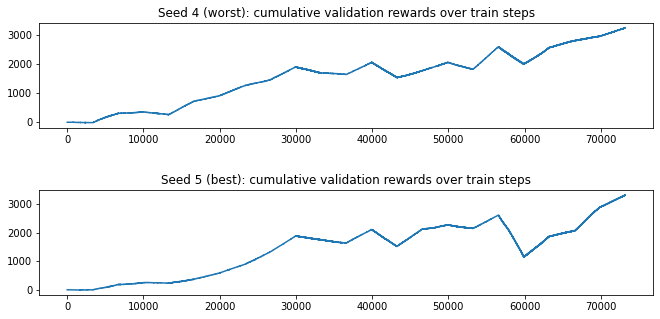

In [148]:
# one plot for each seed, all episodes combined, over all timesteps, cumulative reward on validation set

# best seed 5, worst 4
subplots = 2

title_pad = 18.
label_pad = 8#10.          
space_between_plots=0.6
lines_list = []

title_fontsize = 20
label_fontsize = 18
tickfont = 18

fig, ax = plt.subplots(nrows=subplots, 
                       ncols=1, 
                       figsize=(11,5),
                       gridspec_kw={
                           'width_ratios': [1],
                           'height_ratios': [1, 1], 
                           'wspace': 0.1, 'hspace': space_between_plots})
axnum = 0
### note: validation rewards are 
for seednum, seed in enumerate(seedlist):
    if seednum == 4-1 or seednum == 5-1:
        if seednum == 4-1:
            title = f"Seed {seednum+1} (worst): cumulative validation rewards over train steps"
        if seednum == 5-1:
            title = f"Seed {seednum+1} (best): cumulative validation rewards over train steps"
        all_li = []
        for ep in range(1,23):
            li=[]
            for i in range(1,53):
                filepath = glob.glob(os.path.join(results_folder_path, seed, "rewards", f"*validation*ep{ep}_*er_{i}.csv"))[0]
                df = pd.read_csv(filepath, index_col=0)
                df.rename(columns={df.columns[1]: "reward"}, inplace=True)
                li.append(df)
            df = pd.concat(li, axis=0, ignore_index=True)
            df.rename(columns={df.columns[0]: "datadate"}, inplace=True)
            df["datadate"] = pd.to_datetime(df["datadate"], format='%Y%m%d')
            all_li.append(df)
        final_df = pd.concat(all_li, axis=0, ignore_index=True)
        ax[axnum].plot(final_df.index, final_df.reward.cumsum())
        ax[axnum].set_title(title)
        axnum+=1
plt.savefig(os.path.join(abspath, "analysis", "results", "model1", "valrewards1.png"), bbox_inches="tight")

In [ ]:
### TRAINING PERFORMANCE

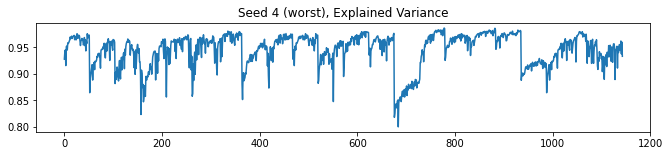

<Figure size 432x288 with 0 Axes>

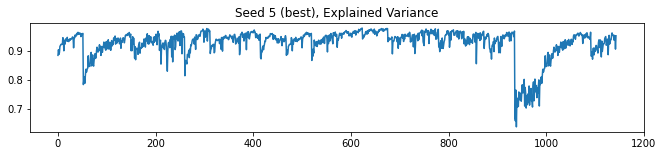

<Figure size 432x288 with 0 Axes>

In [164]:
# one plot for each seed, all episodes combined, over all timesteps, cumulative reward on validation set
for seednum, seed in enumerate(seedlist):
    # best seed 5, worst 4
    if seednum == 4-1 or seednum == 5-1:
        if seednum == 4-1:
            title = f"Seed {seednum+1} (worst), Explained Variance"
        if seednum == 5-1:
            title = f"Seed {seednum+1} (best), Explained Variance"
        li = []
        for ep in range(1,23):
            filepath = glob.glob(os.path.join(results_folder_path, seed, "training_performance", 
                                              f"explained_variance_*ep{ep}*.csv"))[0]
            df = pd.read_csv(filepath, index_col=0)
            df.rename(columns={df.columns[0]: "explained_variance"}, inplace=True)
            #plt.plot(final_df.index, final_df.explained_variance)
            #plt.title(f"Seed {seednum}, Episode {ep}: Explained Variance over training iterations")
            #plt.show()
            #plt.clf()
            li.append(df)
        df = pd.concat(li, axis=0, ignore_index=True)
        all_li.append(df)
        plt.figure(figsize=(11,2))
        plt.plot(df.index, df.explained_variance)
        plt.title(title)
        plt.show()
        plt.clf()
        # TODO: need to have same axis and axis labels. make randomseed names as numbers (enumaerate)
        # note: ue episode name in different conext like this is wrong
    #final_df = pd.concat(all_li, axis=0, ignore_index=True)
    #plt.plot(final_df.index, final_df.explained_variance)
   # plt.title(f"All seeds, all episodes: explained variance")
   # plt.show()
   # plt.clf()
plt.savefig(os.path.join(abspath, "analysis", "results", "model1", "model1_explained_variance.png"), bbox_inches="tight")

AttributeError: 'DataFrame' object has no attribute 'actor_loss'

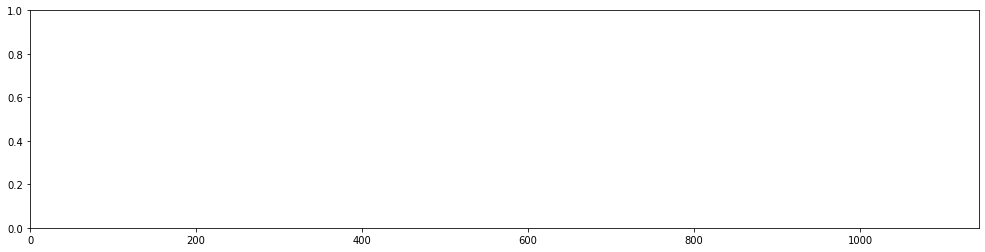

In [165]:
### TRAIN PERFORMANCES: ACTOR LOSS (POLICY LOSS)
# one plot for each seed, all episodes combined, over all timesteps, cumulative reward on validation set
for seednum, seed in enumerate(seedlist):
    epwindow_end = 0 
    df_all = pd.concat(li, axis=0, ignore_index=True)
    all_li.append(df)
    plt.figure(figsize=(17,4))
    plt.xlim(left=df_all.index[0], right=df_all.index[-1])
    plt.plot(df_all.index, df_all.actor_loss)
    for ep in range(1,23):
        epwindow_end += df.index[-1]
        plt.axvline(x=epwindow_end,  color='black')
    plt.axhline(y=0, color="r")
    plt.title(f"Seed {seednum+1}, all episodes: policy loss")
    plt.show()
    plt.clf()
    # TODO: need to have same axis and axis labels. make randomseed names as numbers (enumaerate)
    # note: ue episode name in different conext like this is wrong

AttributeError: 'DataFrame' object has no attribute 'critic_loss'

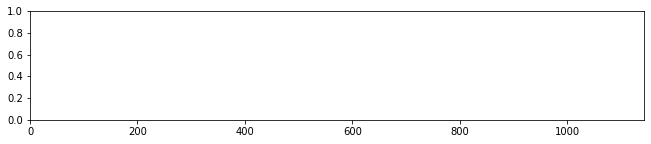

In [166]:
### TRAIN PERFORMANCES: CRITIC LOSS (VALUE LOSS)
# one plot for each seed, all episodes combined, over all timesteps, cumulative reward on validation set
for seednum, seed in enumerate(seedlist):
    if seednum == 4-1 or seednum == 5-1:
        # best seed 5, worst 4
        if seednum == 4-1:
            title = f"Seed {seednum+1} (worst): value loss"
        if seednum == 5-1:
            title = f"Seed {seednum+1} (best): value loss"
        epwindow_end = 0 
        df_all = pd.concat(li, axis=0, ignore_index=True)
        all_li.append(df)
        plt.figure(figsize=(11,2))
        plt.xlim(left=df_all.index[0], right=df_all.index[-1])
        plt.plot(df_all.index, df_all.critic_loss)
        for ep in range(1,23):
            epwindow_end += df.index[-1]
            plt.axvline(x=epwindow_end,  color='black')
        plt.axhline(y=0, color="r")
        plt.title(title)
        plt.show()
        plt.clf()
    # TODO: need to have same axis and axis labels. make randomseed names as numbers (enumaerate)
    # note: ue episode name in different conext like this is wrong
plt.savefig(os.path.join(abspath, "analysis", "results", "model1", "model1_value_loss.png"), bbox_inches="tight")

AttributeError: 'DataFrame' object has no attribute 'entropy_loss'

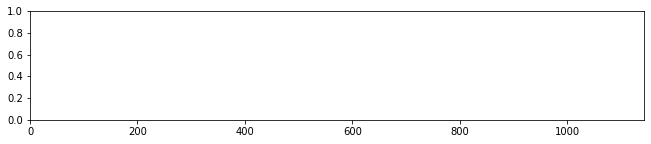

In [167]:
### TRAIN PERFORMANCES: MEAN ENTROPY (-MEAN ENTROPY LOSS)
# one plot for each seed, all episodes combined, over all timesteps, cumulative reward on validation set
for seednum, seed in enumerate(seedlist):
    if seednum == 4-1 or seednum == 5-1:
        # best seed 5, worst 4
        if seednum == 4-1:
            title = f"Seed {seednum+1} (worst): mean entropy (over minibatch)"
        if seednum == 5-1:
            title = f"Seed {seednum+1} (best): mean entropy (over minibatch)"
        epwindow_end = 0 
        df_all = pd.concat(li, axis=0, ignore_index=True)
        all_li.append(df)
        plt.figure(figsize=(11,2))
        plt.xlim(left=df_all.index[0], right=df_all.index[-1])
        plt.plot(df_all.index, (-1)*df_all.entropy_loss)
        for ep in range(1,23):
            epwindow_end += df.index[-1]
            plt.axvline(x=epwindow_end,  color='black')
        plt.axhline(y=0, color="r")
        plt.title(title)
        plt.savefig(os.path.join(abspath, "analysis", "results", "model1", f"entropy1_{seednum}.png"), bbox_inches="tight")
    # TODO: need to have same axis and axis labels. make randomseed names as numbers (enumaerate)
    # note: ue episode name in different conext like this is wrong
    
# entropy loss starts high at the beginning of each episode and then drops
# https://medium.com/aureliantactics/understanding-ppo-plots-in-tensorboard-cbc3199b9ba2
# shows how random actions are. Should decrease steadily during training process. Here looks ok.
# Entropy: "the higher the more bonus" => to max.
# Entropy loss = neg. Entropy => to min. => "the lower, the better"
# idea is that in the beginning, we get a bonus for more exploration

# about losses: 
# https://www.reddit.com/r/reinforcementlearning/comments/bse7l5/rl_ppo_alrorithm_understanding_value_loss_and/



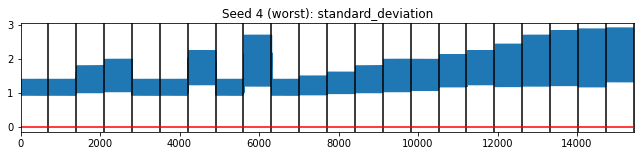

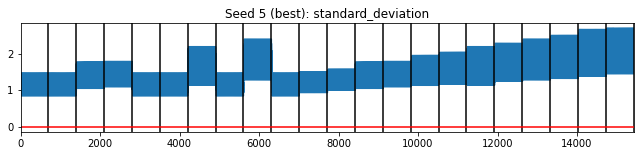

In [168]:
### TRAIN PERFORMANCES: STANDARD DEVIATIONS
# one plot for each seed, all episodes combined, over all timesteps, cumulative reward on validation set
for seednum, seed in enumerate(seedlist):
    if seednum == 4-1 or seednum == 5-1:
        # best seed 5, worst 4
        if seednum == 4-1:
            title = f"Seed {seednum+1} (worst): standard_deviation"
        if seednum == 5-1:
            title = f"Seed {seednum+1} (best): standard_deviation"
        li = []
        for ep in range(1,23):
            filepath = glob.glob(os.path.join(results_folder_path, seed, "training_performance", 
                                              f"standard_deviations*{ep}*.csv"))[0]
            df = pd.read_csv(filepath, index_col=0)
            df.rename(columns={df.columns[0]: "standard_deviation"}, inplace=True)
            # plot
            #plt.plot(df.index, df.actor_loss)
            #plt.axvline(x=epwindow_end)
            #plt.title(f"Seed {seednum}, Episode {ep}: Explained Variance over training iterations")
            #plt.show()
            #plt.clf()
            li.append(df)
        epwindow_end = 0 
        df_all = pd.concat(li, axis=0, ignore_index=True)
        all_li.append(df)
        plt.figure(figsize=(11,2))
        plt.xlim(left=df_all.index[0], right=df_all.index[-1])
        plt.plot(df_all.index, df_all.standard_deviation)
        for ep in range(1,23):
            epwindow_end += df.index[-1]
            plt.axvline(x=epwindow_end,  color='black')
        plt.axhline(y=0, color="r")
        plt.title(title)
        plt.savefig(os.path.join(abspath, "analysis", "results", "model1", f"std1_{seednum}.png"), bbox_inches="tight")
    # TODO: need to have same axis and axis labels. make randomseed names as numbers (enumaerate)
    # note: ue episode name in different conext like this is wrong
#plt.savefig(os.path.join(abspath, "analysis", "results", "model1", "std1.png"), bbox_inches="tight")

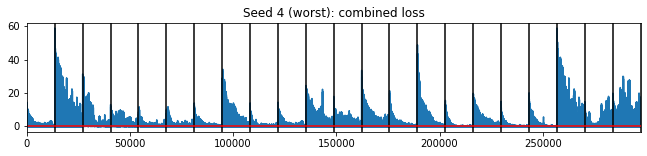

<Figure size 432x288 with 0 Axes>

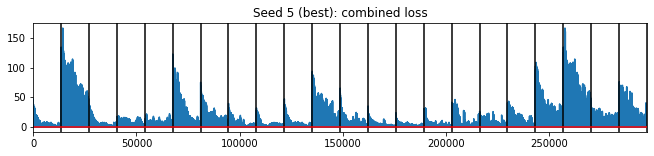

<Figure size 432x288 with 0 Axes>

In [169]:
### TRAIN PERFORMANCES: COMBINED LOSS
# one plot for each seed, all episodes combined, over all timesteps, cumulative reward on validation set
for seednum, seed in enumerate(seedlist):
    if seednum == 4-1 or seednum == 5-1:
        # best seed 5, worst 4
        if seednum == 4-1:
            title = f"Seed {seednum+1} (worst): combined loss"
        if seednum == 5-1:
            title = f"Seed {seednum+1} (best): combined loss"
        li = []
        for ep in range(1,23):
            filepath = glob.glob(os.path.join(results_folder_path, seed, "training_performance", 
                                              f"train_performances_ep{ep}*.csv"))[0]
            df = pd.read_csv(filepath, index_col=0)
            # plot
            #plt.plot(df.index, df.actor_loss)
            #plt.axvline(x=epwindow_end)
            #plt.title(f"Seed {seednum}, Episode {ep}: Explained Variance over training iterations")
            #plt.show()
            #plt.clf()
            li.append(df)
        epwindow_end = 0 
        df_all = pd.concat(li, axis=0, ignore_index=True)
        all_li.append(df)
        plt.figure(figsize=(11,2))
        plt.xlim(left=df_all.index[0], right=df_all.index[-1])
        plt.plot(df_all.index, df_all.combined_loss)
        for ep in range(1,23):
            epwindow_end += df.index[-1]
            plt.axvline(x=epwindow_end,  color='black')
        plt.axhline(y=0, color="r")
        plt.title(title)
        plt.show()
        plt.clf()
        plt.savefig(os.path.join(abspath, "analysis", "results", "model1", f"model1_combined_loss_{seednum}.png"), bbox_inches="tight")
        # TODO: need to have same axis and axis labels. make randomseed names as numbers (enumaerate)
        # note: ue episode name in different conext like this is wrong


In [187]:
### entropy loss

worst = "randomSeed7774"
for ep in range(1,23):
    filepath = glob.glob(os.path.join(results_folder_path, worst, "training_performance", 
                                      f"train_performances_ep{ep}*.csv"))[0]
    df = pd.read_csv(filepath, index_col=0)
    # plot
    #plt.plot(df.index, df.actor_loss)
    #plt.axvline(x=epwindow_end)
    #plt.title(f"Seed {seednum}, Episode {ep}: Explained Variance over training iterations")
    #plt.show()
    #plt.clf()
    li.append(df)
epwindow_end = 0 
df_all = pd.concat(li, axis=0, ignore_index=True)

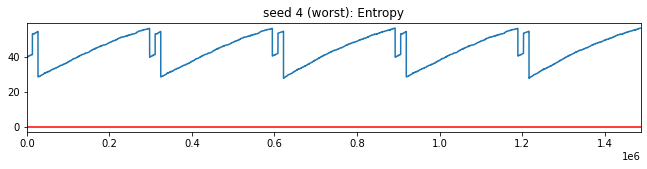

In [188]:
plt.figure(figsize=(11,2))
plt.xlim(left=df_all.index[0], right=df_all.index[-1])
plt.plot(df_all.index, (-1)*df_all.entropy_loss)

plt.axhline(y=0, color="r")
plt.title("seed 4 (worst): Entropy")
plt.savefig(os.path.join(abspath, 
                         "analysis", 
                         "results", 
                             "model1", f"entropy1_worst.png"), bbox_inches="tight")

In [189]:
best = "randomSeed11112"
for ep in range(1,23):
    filepath = glob.glob(os.path.join(results_folder_path, best, "training_performance", 
                                      f"train_performances_ep{ep}*.csv"))[0]
    df = pd.read_csv(filepath, index_col=0)
    # plot
    #plt.plot(df.index, df.actor_loss)
    #plt.axvline(x=epwindow_end)
    #plt.title(f"Seed {seednum}, Episode {ep}: Explained Variance over training iterations")
    #plt.show()
    #plt.clf()
    li.append(df)
epwindow_end = 0 
df_all = pd.concat(li, axis=0, ignore_index=True)

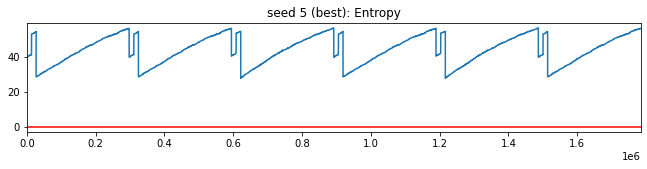

In [190]:
plt.figure(figsize=(11,2))
plt.xlim(left=df_all.index[0], right=df_all.index[-1])
plt.plot(df_all.index, (-1)*df_all.entropy_loss)

plt.axhline(y=0, color="r")
plt.title("seed 5 (best): Entropy")
plt.savefig(os.path.join(abspath, 
                         "analysis", 
                         "results", 
                             "model1", f"entropy1_best.png"), bbox_inches="tight")